# Read Data

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 

columns = ["Cancelled", "DepDelayMinutes", "Distance", "Airline", "Dest", "DestStateName", "Origin", "OriginStateName", "DayOfWeek", "CRSDepTime", "DepTimeBlk", "Month"]

df = pd.read_parquet('Combined_Flights_2022.parquet', columns=columns)

print(df.shape)

(4078318, 12)


# Construct New Columns

In [2]:
# Turn departure delay column into categorical features
df['OnTime'] = df['DepDelayMinutes'] == 0
df['SlightDelay'] = (df['DepDelayMinutes'] <= 15) & (df['DepDelayMinutes'] > 0)
df['MediumDelay'] = (df['DepDelayMinutes'] <= 45) & (df['DepDelayMinutes'] > 15)
df['LargeDelay'] = df['DepDelayMinutes'] > 45

# Make sure these categories are "one-hot" encoded
df.loc[df['Cancelled'], 'OnTime'] = False
df.loc[df['Cancelled'], 'SlightDelay'] = False
df.loc[df['Cancelled'], 'MediumDelay'] = False
df.loc[df['Cancelled'], 'LargeDelay'] = False

# Merge the columns into a single label
df['FlightStatus'] = df[['Cancelled','OnTime','SlightDelay','MediumDelay','LargeDelay']].idxmax(1).astype('category')

print(df.shape)

(4078318, 17)


# Exploratory Data Analysis

<Figure size 500x300 with 0 Axes>

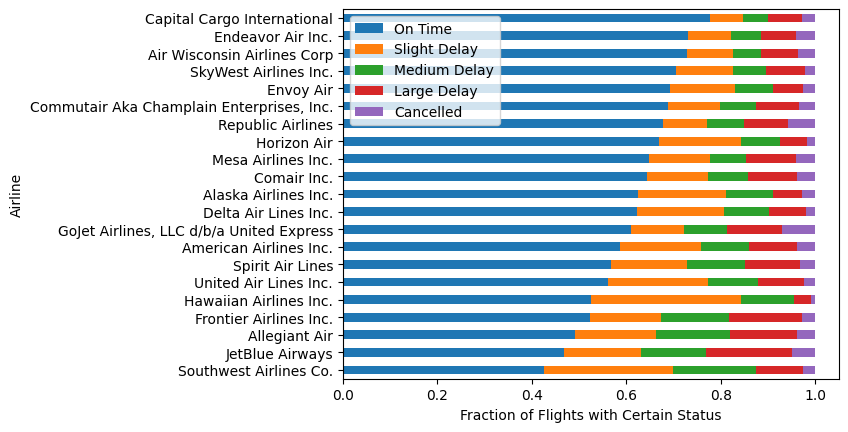

In [3]:
count_matrix = df.groupby(['Airline', 'FlightStatus']).size().unstack()
count_matrix.columns = pd.CategoricalIndex(count_matrix.columns.values, ordered=True, categories=['OnTime', 'SlightDelay', 'MediumDelay', 'LargeDelay', 'Cancelled'])
count_matrix = count_matrix.sort_index(axis=1)
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.sort_values('OnTime', inplace=True)

plt.figure(figsize=(5,3))
count_matrix_norm.plot(kind='barh', stacked=True)
plt.xlabel('Fraction of Flights with Certain Status')
plt.legend(["On Time", "Slight Delay", "Medium Delay", "Large Delay", "Cancelled"], loc=0)
plt.show()

It seems that passenger airlines are much more likely to be delayed than cargo airlines. We see many familiar Airlines near the bottom of the On Time percentage, while lesser known shipping Airlines like "Capital Cargo Internation" have stellar On Time percentages.

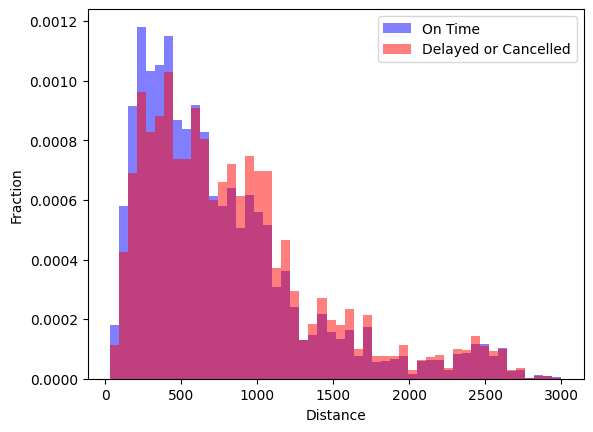

In [4]:
bin_range = (df['Distance'].min(), 3000)

bins = 50

plt.hist(df[df['OnTime']==True]['Distance'],alpha=0.5,label="On Time",range=bin_range,bins=bins,density=True, color="blue")
plt.hist(df[df['OnTime']==False]['Distance'],alpha=0.5,label="Delayed or Cancelled",range=bin_range,bins=bins,density=True,color="red")
plt.legend()
plt.ylabel('Fraction')
plt.xlabel('Distance')
plt.show()

It seems that flights are slightly more likely to be on time when flying short distances than longer distances. Overall this is a less significant effect than I had initially expected.

Text(0, 0.5, 'Number of Cancellations')

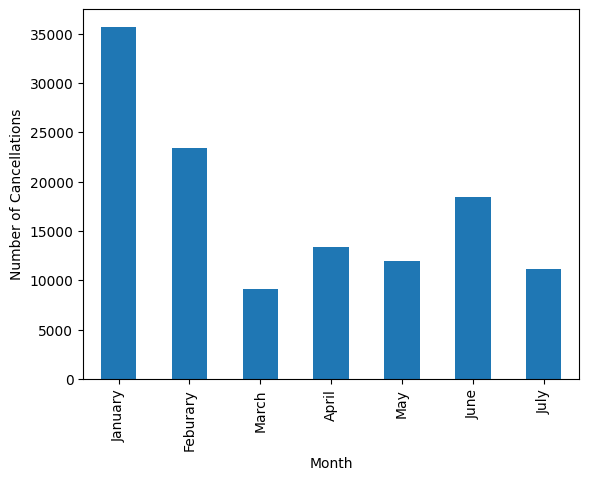

In [12]:
count_df = pd.DataFrame(df[df["Cancelled"]==True].groupby(['Month']).size())
fig, ax = plt.subplots()
count_df.plot(kind="bar", legend=False, ax=ax)
ax.set_xticklabels(["January", "Feburary", "March", "April", "May", "June", "July"])
ax.set_ylabel("Number of Cancellations")

I remembered that over the Summer there seemed to a lot of flight cancellations. I wanted to check this against the actual data, and was shocked that flight cancellations did not reach the peak of January and Feburary of this year.

<Figure size 500x1000 with 0 Axes>

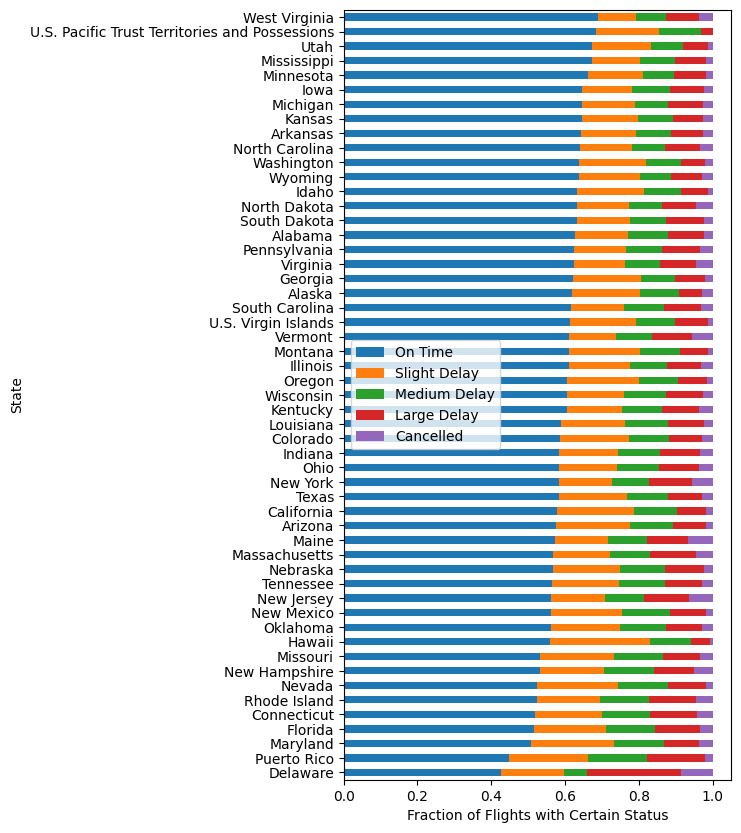

In [13]:
count_matrix = df.groupby(['DestStateName', 'FlightStatus']).size().unstack()
count_matrix.columns = pd.CategoricalIndex(count_matrix.columns.values, ordered=True, categories=['OnTime', 'SlightDelay', 'MediumDelay', 'LargeDelay', 'Cancelled'])
count_matrix = count_matrix.sort_index(axis=1)
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.sort_values('OnTime', inplace=True)

plt.rcParams['figure.figsize'] = (5, 10)
plt.figure(figsize=(5,10))
count_matrix_norm.plot(kind='barh', stacked=True)
plt.xlabel('Fraction of Flights with Certain Status')
plt.ylabel('State')
plt.legend(["On Time", "Slight Delay", "Medium Delay", "Large Delay", "Cancelled"], loc=0)
plt.show()

# Splitting and Preprocessing 

In [15]:
# Check for missing values
perc_missing_per_ftr = df.isnull().sum(axis=0)/df.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

# Replace NaN features with 0
df['DepDelayMinutes'] = df['DepDelayMinutes'].fillna(0)

fraction of missing values in features:
Series([], dtype: float64)


/var/folders/38/b7c3pzmn4k32tkrt_9pyfxp00000gn/T/ipykernel_19735/31317678.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DepDelayMinutes'] = df['DepDelayMinutes'].fillna(0)


In [16]:
def basic_split(X, y, train_size, val_size, test_size, random_state):
    
    # test the inputs
    if train_size + val_size + test_size != 1:
        raise ValueError("Sum of split sizes does not equal 1")
    if not isinstance(random_state, int):
        raise ValueError("Random state must be an integer")
    
    
    # perform basic split
    X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=val_size+test_size, random_state=random_state)
    X_test, X_val, y_test, y_val = train_test_split(X_other, y_other, test_size=val_size/(val_size + test_size), random_state=random_state)
    
    # test the outputs
    
    true_train_size = len(X_train)/len(X)
    true_test_size = len(X_test)/len(X)
    true_val_size = len(X_val)/len(X)
    
    if not math.isclose(true_train_size, train_size, abs_tol=0.01):
        raise ValueError(f"Incorrect train size, {true_train_size}")
    if not math.isclose(true_test_size, test_size, abs_tol=0.01):
        raise ValueError(f"Incorrect test size, {true_test_size}")
    if not math.isclose(true_val_size, val_size, abs_tol=0.01):
        raise ValueError(f"Incorrect validation size, {true_val_size}")

    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

X = df.drop(['Cancelled','OnTime','SlightDelay','MediumDelay','LargeDelay', 'DepDelayMinutes', 'FlightStatus'], axis=1)
y = df['FlightStatus']

X_train, y_train, X_val, y_val, X_test, y_test = basic_split(X, y, 0.95, 0.025, 0.025, random_state=1)

onehot_ftrs = ["Airline", "Dest", "DestStateName", "Origin", "OriginStateName", "DayOfWeek", "DepTimeBlk", "Month"]
std_ftrs = ['Distance','CRSDepTime']

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), onehot_ftrs),
        ('std', StandardScaler(), std_ftrs)])

clf = Pipeline(steps=[('preprocessor', preprocessor)])

X_train_prep = clf.fit_transform(X_train)
X_val_prep = clf.transform(X_val)
X_test_prep = clf.transform(X_test)

print(X_train_prep.shape)
print(X_val_prep.shape)
print(X_test_prep.shape)

(3759931, 912)
(98946, 912)
(98946, 912)
